# Проект для интернет-магазина

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок. Постройть модель со значением метрики качества *F1* не меньше 0.75. 

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline


import re
import nltk
nltk.download(['stopwords', 'averaged_perceptron_tagger', 'punkt', 'wordnet', 'omw-1.4'])
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

from nltk import sent_tokenize, word_tokenize

from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as metrics
from sklearn.metrics import f1_score

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...


In [2]:
try:
    data = pd.read_csv('C:/Users/Ксения/data_analyst/vikishop/toxic_comments.csv')
except:
    data = pd.read_csv('/datasets/toxic_comments.csv')
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


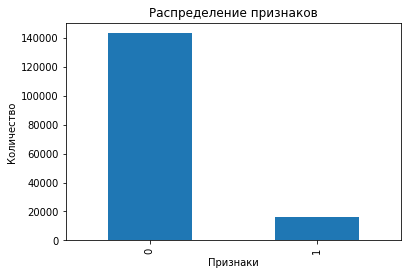

In [4]:
data['toxic'].value_counts().plot(kind='bar')
plt.title ('Распределение признаков')
plt.xlabel('Признаки')
plt.ylabel('Количество')
None

In [5]:
# Избавимся от лишнего
data = data.drop('Unnamed: 0' , axis=1)

In [6]:
def clearing(text):
    text = re.sub(r"(?:\n|\r)", " ", text)
    text = re.sub(r"[^a-zA-Z ]+", "", text).strip()
    text = text.lower()
    return text
data['text'] = data['text'].apply(clearing)
data = data.drop_duplicates().reset_index(drop= True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158285 entries, 0 to 158284
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    158285 non-null  object
 1   toxic   158285 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [7]:
data.head()

,text,toxic
0,explanation why the edits made under my userna...,0
1,daww he matches this background colour im seem...,0
2,hey man im really not trying to edit war its j...,0
3,more i cant make any real suggestions on impro...,0
4,you sir are my hero any chance you remember wh...,0


In [8]:
wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

def lemmatize_sent(text): 
       return ' '.join([wnl.lemmatize(word.lower(), pos=penn2morphy(tag))
            for word, tag in pos_tag(word_tokenize(text))]) 


print(lemmatize_sent("The striped bats are hanging on their feet for best"))

the striped bat be hang on their foot for best


In [9]:
from tqdm.notebook import tqdm
tqdm.pandas()
data['lemm_text'] = data['text'].progress_apply(lemmatize_sent)

  0%|          | 0/158285 [00:00<?, ?it/s]

In [10]:
data.head(15)

,text,toxic,lemm_text
0,explanation why the edits made under my userna...,0,explanation why the edits make under my userna...
1,daww he matches this background colour im seem...,0,daww he match this background colour im seemin...
2,hey man im really not trying to edit war its j...,0,hey man im really not try to edit war it just ...
3,more i cant make any real suggestions on impro...,0,more i cant make any real suggestion on improv...
4,you sir are my hero any chance you remember wh...,0,you sir be my hero any chance you remember wha...
5,congratulations from me as well use the tools ...,0,congratulation from me a well use the tool wel...
6,cocksucker before you piss around on my work,1,cocksucker before you piss around on my work
7,your vandalism to the matt shirvington article...,0,your vandalism to the matt shirvington article...
8,sorry if the word nonsense was offensive to yo...,0,sorry if the word nonsense be offensive to you...
9,alignment on this subject and which are contra...,0,alignment on this subject and which be contrar...


In [11]:
# Посмотрим на токсичные слова
data[data['toxic']==1]['lemm_text'].unique()

array(['cocksucker before you piss around on my work',
       'hey what be it talk what be it an exclusive group of some wp talibanswho be good at destroy selfappointed purist who gang up any one who ask them question abt their antisocial and destructive noncontribution at wp ask sityush to clean up his behavior than issue me nonsensical warning',
       'bye dont look come or think of comming back tosser', ...,
       'your absurd edits your absurd edits on great white shark be total vandalism and be very sexual all you edit here be fuck bullshit like spam all over this useful encyclopedia so stop all your bullshit the admins have you everywhere the only choice for you be to stop this bullshit or else youll be block permanently userfactualman',
       'hey listen dont you ever delete my edits ever again im annoy because the wwe k a few of the roster have be confirm and your stupid as delete what i write just stop please stop you dont work k or wwe game so stop delete other people shit

**Выводы:**
- в датасете нет пропусков
- судя по графику распределения, нетоксичных комментариев значительно больше
- основной текст комментариев был в разных регистрах, для удобства переведен в нижний
- после приведения текста к единому регистру были удалены дубликаты
- удален неинформативный столбец с индексами
- проведена очистка текста от лишних символов
- проведена лемматизация слов

## Обучение

In [12]:
# Разделение по выборкам
random_state = 888888
features = data['lemm_text']
target = data['toxic']

f_train, f_test, t_train, t_test= train_test_split(features, target, test_size = 0.25, random_state = random_state)

print(f_train.shape)
print(f_test.shape)
print(t_train.shape)
print(t_test.shape)

(118713,)
(39572,)
(118713,)
(39572,)


In [13]:
#TFIDF векторизация
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tfidf_train = count_tf_idf.fit_transform(f_train)
tfidf_test = count_tf_idf.transform(f_test)


tfidf_train.shape[0], tfidf_test.shape[0]

(118713, 39572)

In [14]:
%%time


param_lr = {'penalty': ['l1', 'l2'],
            'C': list(range(1,21,3))
        }

model_lr = LogisticRegression(random_state=random_state, max_iter=180)

grid_1 = GridSearchCV(model_lr, param_grid=param_lr, scoring='f1', cv=3, verbose=True, n_jobs=-1)
best_grid = grid_1.fit(tfidf_train, t_train)
print('Best parameters is:', grid_1.best_params_)
print('Best score is:', grid_1.best_score_)

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Best parameters is: {'C': 13, 'penalty': 'l2'}
Best score is: 0.7540592629414373
CPU times: total: 1min 1s
Wall time: 1min 23s


In [15]:
%%time
params_forest = {
    'n_estimators': list(range(20,200,20)),
    'max_depth':[5,15],
    'max_features' : list(range(1,20, 2))
}


model_forest = RandomForestClassifier(random_state=random_state)
                                 
grid_2 = GridSearchCV(model_forest, param_grid=params_forest, scoring='f1', cv=3, verbose=True, n_jobs=-1)
best_grid_2 = grid_2.fit(tfidf_train, t_train)
print('Best parameters is:', grid_2.best_params_)
print('Best score is:', grid_2.best_score_)

Fitting 3 folds for each of 180 candidates, totalling 540 fits
Best parameters is: {'max_depth': 5, 'max_features': 1, 'n_estimators': 20}
Best score is: 0.0
CPU times: total: 15.4 s
Wall time: 16min 47s


**Выводы:**
Для обучения и поиска лучших гиперпараметров были взяты 2 модели: LogisticRegression и RandomForestClassifier. 

Результаты обучения LogisticRegression:
- Best parameters is: {'C': 13, 'penalty': 'l2'}
- Best score is: 0.7540592629414373
- CPU times: total: 1min 1s
- Wall time: 1min 23s

Результаты RandomForestClassifier:
- Best parameters is: {'max_depth': 5, 'max_features': 1, 'n_estimators': 20}
- Best score is: 0.0
- CPU times: total: 15.4 s
- Wall time: 16min 47s

Метрика Best score модели LogisticRegression удовлетворяет требования ТЗ, она больше 0.75. Поэтому для тестирования возьмем ее.

In [18]:
test_pred = grid_1.best_estimator_.predict(tfidf_test)

print('Метрика F1:',f1_score(t_test, test_pred))

Метрика F1: 0.7644370585791441


## Выводы

Значение метрики F1 выше требуемой, а значит модель подобрана правильно 